In [2]:
# %%capture
!rm -rf ./data/
!mkdir -p ./data/
!wget -c -O ./data/weather-data.tar.gz "https://github.com/00ber/ml-weather-prediction/blob/main/training/src/data/weather-data.tar.gz?raw=true"
!tar xvfz ./data/weather-data.tar.gz --directory ./data
!ls data
!pip install pandas numpy requests-cache

from google.colab import drive
drive.mount('/content/drive')


--2022-12-14 03:16:45--  https://github.com/00ber/ml-weather-prediction/blob/main/training/src/data/weather-data.tar.gz?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/00ber/ml-weather-prediction/raw/main/training/src/data/weather-data.tar.gz [following]
--2022-12-14 03:16:46--  https://github.com/00ber/ml-weather-prediction/raw/main/training/src/data/weather-data.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/00ber/ml-weather-prediction/main/training/src/data/weather-data.tar.gz [following]
--2022-12-14 03:16:46--  https://raw.githubusercontent.com/00ber/ml-weather-prediction/main/training/src/data/weather-data.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199

In [3]:
import os
import sqlite3
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import requests
import requests_cache
from requests_cache.backends.sqlite import SQLiteCache
import sqlite3
import datetime
from datetime import date, timedelta, timezone
import time
import pytz

local_tz = pytz.timezone('America/New_York')


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# initialize cache
requests_cache.install_cache('./data/weather_api_cache')

In [4]:
#@title Exploratory Data Analysis

conn = sqlite3.connect("./data/weather-raw.db")
df = pd.read_sql("""
SELECT *
FROM weather_raw;
""",
  conn,
  parse_dates=["obs_timestamp"]
)
df.count()

key                          247349
class                        247349
expire_time_gmt              247349
obs_id                       247349
obs_name                     247349
valid_time_gmt               247349
day_ind                      247349
temp                         247318
wx_icon                      247326
icon_extd                    247337
wx_phrase                    247326
pressure_tend                 64965
pressure_desc                 64965
dewPt                        244841
heat_index                   245428
rh                           247320
pressure                     247318
vis                          247329
wc                           246913
wdir                         222524
wdir_cardinal                247234
gust                          29738
wspd                         233964
max_temp                      27730
min_temp                      27522
precip_total                   1075
precip_hourly                128700
snow_hrly                   

Text(0.5, 0, 'NaN counts by column')

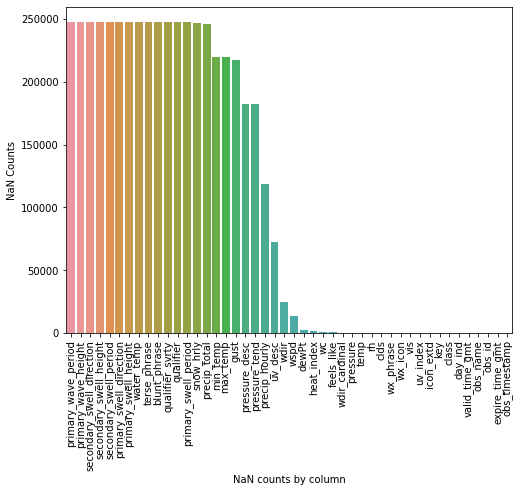

In [5]:
import seaborn as sns
import matplotlib.pylab as plt

ds =  df.isna().sum().sort_values(ascending=False).to_frame()
ds = ds.reset_index()
ds.columns
ds.columns = ["Field Name", "NaN Counts"]
ax = sns.barplot(data=ds, x="Field Name", y="NaN Counts")
plt.xticks(rotation=90)
ax.set_xlabel("NaN counts by column")

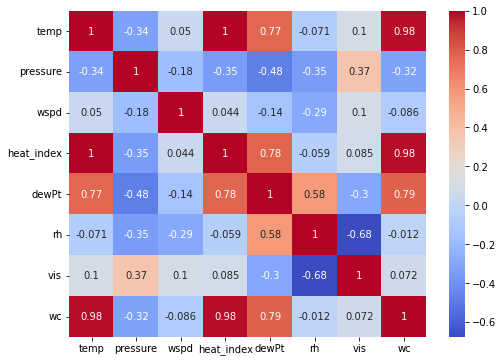

In [6]:
kept_cols = ["temp", "pressure", "wspd", "heat_index", "dewPt", "rh", "vis", "wc", "clds", "wdir_cardinal"]
df2 = df[kept_cols].head(2000)
sns.heatmap(df2.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

Text(0, 0.5, 'Count of observations')

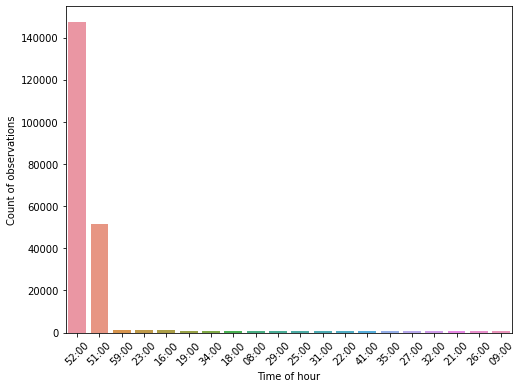

In [7]:
df["obs_time"] = df.apply(lambda x: str(x["obs_timestamp"])[-5:], axis=1)
dfx = df.value_counts(subset=['obs_time']).to_frame()
dfx = dfx.reset_index()
dfx.columns = ["obs_time", "counts"]
ax = sns.barplot(data=dfx.head(20), x="obs_time", y="counts")
plt.xticks(rotation=45)
ax.set_xlabel("Time of hour")
ax.set_ylabel("Count of observations")

In [ ]:

# DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
# API_KEY = "e1f10a1e78da46f5b10a1e78da96f525"
# BASE_URL = "https://api.weather.com/v1/location/KDCA:9:US/observations/historical.json?apiKey={api_key}&units=e&startDate={start_date}&endDate={end_date}"

# # Field descriptions here
# # https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/511371/1/LapamonpinyoEtAl_engrXiv_2021.pdf    
# # Sample
# # {
# #     'key': 'KDCA', 'class': 'observation', 'expire_time_gmt': 946709460, 'obs_id': 'KDCA', 'obs_name': 'Washington/Natl', 
# #     'valid_time_gmt': 946702260, 'day_ind': 'N', 'temp': 41, 'wx_icon': 33, 'icon_extd': 3300, 'wx_phrase': 'Fair', 'pressure_tend': None,
# #     'pressure_desc': None, 'dewPt': 34, 'heat_index': 41, 'rh': 76, 'pressure': 30.19, 'vis': 5, 'wc': 41, 'wdir': None, 
# #     'wdir_cardinal': 'CALM', 'gust': None, 'wspd': None, 'max_temp': 57, 'min_temp': 41, 'precip_total': None, 
# #     'precip_hrly': None, 'snow_hrly': None, 'uv_desc': 'Low', 'feels_like': 41, 'uv_index': 0, 'qualifier': None, 'qualifier_svrty': None,
# #     'blunt_phrase': None, 'terse_phrase': None, 'clds': 'CLR', 'water_temp': None, 'primary_wave_period': None, 'primary_wave_height': None, 
# #     'primary_swell_period': None, 'primary_swell_height': None, 'primary_swell_direction': None, 'secondary_swell_period': None, 
# #     'secondary_swell_height': None, 'secondary_swell_direction': None
# # }

# conn = sqlite3.connect("./data/weather-raw.db")
# cur = conn.cursor()


# def create_weather_table(cur, table_name):
#     cur.execute("""
#     CREATE TABLE IF NOT EXISTS {table_name}(
#         key, class, expire_time_gmt, obs_id, obs_name, valid_time_gmt INTEGER NOT NULL PRIMARY KEY, day_ind, temp, wx_icon, icon_extd, 
#         wx_phrase, pressure_tend, pressure_desc, dewPt, heat_index, rh, pressure, vis, wc, wdir, wdir_cardinal, 
#         gust, wspd, max_temp, min_temp, precip_total, precip_hourly, snow_hrly, uv_desc, feels_like, uv_index,
#         qualifier, qualifier_svrty, blunt_phrase, terse_phrase, clds, water_temp, primary_wave_period, 
#         primary_wave_height, primary_swell_period, primary_swell_height, primary_swell_direction, 
#         secondary_swell_period, secondary_swell_height, secondary_swell_direction, obs_timestamp)
#     """.format(table_name=table_name))

# # Create tables for raw & cleaned data respectively (if they don't exist already)
# create_weather_table(cur, "weather_raw")


# # Get the latest date that data has been downloaded for and start downloading new data from that timestamp
# cur.execute("SELECT MAX(obs_timestamp) FROM weather_raw")
# max_date = cur.fetchone()[0]
# target_date = datetime.datetime.strptime(max_date, DATE_FORMAT).date() if max_date else date(2000, 1, 1)

# print(f"Starting Date: {target_date}")  
# print("--------------------------------")
# defaults = {
#     'key': None,'class': None,'expire_time_gmt': None,'obs_id': None,'obs_name': None,'valid_time_gmt': None,
#     'day_ind': None,'temp': None,'wx_icon': None,'icon_extd': None,'wx_phrase': None,'pressure_tend': None,
#     'pressure_desc': None,'dewPt': None,'heat_index': None,'rh': None,'pressure': None,'vis': None,'wc': None,
#     'wdir': None,'wdir_cardinal': None,'gust': None,'wspd': None,'max_temp': None,'min_temp': None,'precip_total': None,
#     'precip_hrly': None,'snow_hrly': None,'uv_desc': None,'feels_like': None,'uv_index': None,'qualifier': None,
#     'qualifier_svrty': None,'blunt_phrase': None,'terse_phrase': None,'clds': None,'water_temp': None,
#     'primary_wave_period': None,'primary_wave_height': None,'primary_swell_period': None,'primary_swell_height': None,
#     'primary_swell_direction': None,'secondary_swell_period': None,'secondary_swell_height': None,'secondary_swell_direction': None
# }


# INSERT_SQL = """
# INSERT OR IGNORE INTO weather_raw VALUES (
#     :key, :class, :expire_time_gmt, :obs_id, :obs_name, :valid_time_gmt, :day_ind, :temp, :wx_icon, :icon_extd, :wx_phrase,
#     :pressure_tend, :pressure_desc, :dewPt, :heat_index, :rh, :pressure, :vis, :wc, :wdir, :wdir_cardinal,
#     :gust, :wspd, :max_temp, :min_temp, :precip_total, :precip_hrly, :snow_hrly, :uv_desc, :feels_like, :uv_index,
#     :qualifier, :qualifier_svrty, :blunt_phrase, :terse_phrase, :clds, :water_temp, :primary_wave_period,
#     :primary_wave_height, :primary_swell_period, :primary_swell_height, :primary_swell_direction,
#     :secondary_swell_period, :secondary_swell_height, :secondary_swell_direction, :obs_timestamp
# )
# """

# def augment_data(rec):
#     rec["obs_timestamp"] = datetime.datetime.fromtimestamp(rec["valid_time_gmt"]).strftime(DATE_FORMAT)
#     return rec

# today = datetime.date.today()
# if target_date == today:
#     print("Already up to date!")
   
# while target_date != today:
#     print("----- inside loop")
#     end_date = target_date + timedelta(days=1) 
#     start_date_str = target_date.strftime("%Y%m%d")
#     end_date_str = end_date.strftime("%Y%m%d")
#     target_url = BASE_URL.format(api_key=API_KEY, start_date=start_date_str, end_date=start_date_str)
#     res = requests.get(target_url)
#     target_date = end_date

#     data = res.json()
#     if not "observations" in data:
#         print(f"Date: {target_date} NF", end="\r")
#         continue
#     params = ({k: d.get(k, defaults[k])  for k in defaults} for d in data["observations"])
#     params = list(map(augment_data, params))

#     cur.executemany(INSERT_SQL, params)
#     conn.commit()
#     # time.sleep(0.05)
#     # was_cached = "Cache HIT" if res.from_cache else "Cache MISS"
#     print(f"Date: {target_date} OK", end="\r")
#     target_date = end_date

# conn.close()

# # print("-------- getting data from db")
# # SQL_CLEANED_DATA = """
# #     WITH RECURSIVE generate_series(x) AS (
# #         SELECT 0
# #         UNION ALL
# #         SELECT x+1 FROM generate_series LIMIT 24
# #     ), distinct_dates AS (
# #         SELECT DISTINCT DATE(obs_timestamp) AS obs_date
# #         FROM weather_raw wr 
# #         WHERE obs_timestamp >= '2000-01-01'
# #     ), hours AS (
# #         SELECT x AS hrs FROM generate_series
# #     )
# #     SELECT w.temp, w.obs_timestamp, w.pressure, w.wspd
# #     FROM weather_raw w 
# #     JOIN (
# #         SELECT d.obs_date, COUNT(*)
# #         FROM distinct_dates d 
# #         CROSS JOIN hours h 
# #         INNER JOIN (SELECT * FROM weather_raw WHERE STRFTIME('%M', obs_timestamp) in ('51', '52')) wr 
# #             ON DATE(STRFTIME('%Y-%m-%d', wr.obs_timestamp)) = d.obs_date 
# #             AND CAST(STRFTIME('%H', obs_timestamp) AS INTEGER) = h.hrs
# #         GROUP BY d.obs_date
# #         HAVING COUNT(*) = 24
# #     ) d ON d.obs_date = STRFTIME('%Y-%m-%d', w.obs_timestamp) 
# #     WHERE STRFTIME('%M', w.obs_timestamp) in ('51', '52');
# # """

In [8]:

def get_NaN_counts(df):    
    nan_counts = df.isna().sum()
    return pd.concat([nan_counts, ((nan_counts/len(df))*100).round(2)], 
                     axis=1, 
                     keys=["NaN count", "Percentage"])
    
def clds_to_ordinal(row):
  mapping = {
      "SKC": 0,
      "CLR": 0,
      "FEW": 1,
      "SCT": 2,
      "BKN": 3,
      "OVC": 4,
      "VV": 5
  }
  clds = row["clds"]
  if pd.isnull(clds):
      return np.NaN 
  return mapping[clds]

def clean_wspd(row):
  if row["wdir_cardinal"] == "CALM":
    return 0
  return row["wspd"]

def restrict_wspd(row):
  if row["wspd"] < 0:
    return 0
  return row["wspd"]

def restrict_rh(row):
  if row["rh"] < 0:
    return 0
  if row["rh"] > 100:
    return 100
  return row["rh"]

def clean_wdir(row):
  if row["wdir_cardinal"] == "CALM":
    return 0
  return row["wdir"]

def wdir_cardinal_to_deg(row):
    wdir = row["wdir"]
    if not pd.isnull(wdir):
      return wdir 
    cardinal_directions = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5,
        'CALM': 0,
        'VAR': -1
    }
    wdir_cardinal = row["wdir_cardinal"]
   
    return cardinal_directions[wdir_cardinal] if wdir_cardinal in cardinal_directions else np.NaN

def convert_mins_to_52(row):
  d = row["obs_timestamp"]
  if d.minute == 51:
    d = d.replace(minute=52)
  return d

def prepare_dataframe(_df, start_timestamp, end_timestamp):
  # _df["obs_timestamp"] = _df.apply(convert_mins_to_52, axis=1)
  # _df = _df.drop_duplicates(subset='obs_timestamp', keep="first")
  dates_df = pd.DataFrame()
  dates_df["obs_timestamp"] = pd.date_range(start_timestamp, end_timestamp, freq="H")
  _df = dates_df.merge(_df, how='left', on='obs_timestamp')
  # _df["pressure"] = _df.apply(lambda x: float(x["pressure"][:-2]) if x["pressure"] else x["pressure"], axis=1)
  _df = _df.astype(
      {
          'temp': 'float',
          'pressure': 'float',
          'wspd': 'float',
          'heat_index': 'float'
      },
  )

  _df["wdir_cardinal"].fillna(method="bfill", inplace=True)
  _df["wdir_degree"] = _df.apply(wdir_cardinal_to_deg, axis=1)
  _df["clds_ordinal"] = _df.apply(clds_to_ordinal, axis=1)
  _df["temp"].interpolate("polynomial", order=2, inplace=True)
  _df["pressure"].interpolate("polynomial", order=2, inplace=True)
  _df["heat_index"].interpolate("polynomial", order=2, inplace=True)
  _df["wdir"].fillna(method="bfill", inplace=True)
  _df["wdir"] = _df.apply(clean_wdir, axis=1)
  _df["wspd"] = _df.apply(clean_wspd, axis=1)
  _df["wspd"].interpolate("polynomial", order=2, inplace=True)
  _df["wspd"] = _df.apply(restrict_wspd, axis=1)
  _df["clds"].fillna(method="bfill", inplace=True)
  _df["clds_ordinal"].interpolate("linear", inplace=True)
  _df["dewPt"].interpolate("polynomial", order=2, inplace=True)
  _df["rh"].interpolate("polynomial", order=2, inplace=True)
  _df["rh"] = _df.apply(restrict_rh, axis=1)
  _df["wc"].interpolate("polynomial", order=2, inplace=True)
  _df["vis"].fillna(method="bfill", inplace=True)
  _df.drop(["wdir", "wdir_cardinal", "clds"], axis=1, inplace=True)
  _df = _df.dropna()
  _df = _df.sort_values(by=['obs_timestamp'])
  date_time = _df.pop('obs_timestamp')
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  day = 24*60*60
  year = (365.2425)*day
  
  _df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  _df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  _df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  _df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
  _df['wdir_sin'] = np.sin(_df["wdir_degree"])
  _df['wdir_cos'] = np.cos(_df["wdir_degree"])
  
  return _df, date_time

# Field descriptions here
# https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/511371/1/LapamonpinyoEtAl_engrXiv_2021.pdf  
conn = sqlite3.connect("./data/weather-clean.db")
df = pd.read_sql("""
SELECT 
  temp, obs_timestamp, pressure, wspd, 
  heat_index, dewPt, rh, vis, wc,
  wdir, wdir_cardinal, clds
FROM weather_clean
WHERE DATE(obs_timestamp) >= '2012-01-01'
  AND DATE(obs_timestamp) < '2022-11-25'
""",
  conn,
  parse_dates=["obs_timestamp"]
)

# conn = sqlite3.connect("./data/weather-clean.db")
# df = pd.read_sql("""
# SELECT 
#   temp, obs_timestamp, pressure, wspd, 
#   heat_index, dewPt, rh, vis, wc, clds, wdir, wdir_cardinal
# FROM weather_clean
# WHERE DATE(obs_timestamp) >= '2012-11-24'
#   AND DATE(obs_timestamp) < '2022-11-25'
# """,
#   conn,
#   parse_dates=["obs_timestamp"]
# )
# df = pd.read_sql("""
# SELECT 
#   temp, obs_timestamp, pressure, wspd, 
#   heat_index, dewPt, rh, vis, wc, clds, wdir_cardinal
# FROM weather_raw
# WHERE DATE(obs_timestamp) >= '2000-02-15'
#   AND DATE(obs_timestamp) < '2000-03-09'
# """,
#   conn,
#   parse_dates=["obs_timestamp"]
# )


df, date_time = prepare_dataframe(df, "2012-01-01 00:52:00", "2022-11-24 23:52:00")
# df, date_time = prepare_dataframe(df, "2000-02-15 00:52:00", "2000-03-09 23:52:00")
df.head()


,temp,pressure,wspd,heat_index,dewPt,rh,vis,wc,wdir_degree,clds_ordinal,day_sin,day_cos,year_sin,year_cos,wdir_sin,wdir_cos
0,53.0,30.08,9.0,53.0,38.0,57.0,10.0,53.0,320.0,3.0,0.224951,0.974370,-0.002561,0.999997,-0.428155,0.903705
1,52.0,30.08,8.0,52.0,37.0,57.0,10.0,52.0,340.0,3.0,0.469472,0.882948,-0.001845,0.999998,0.650311,0.759668
2,50.0,30.10,6.0,50.0,37.0,61.0,10.0,50.0,320.0,1.0,0.681998,0.731354,-0.001128,0.999999,-0.428155,0.903705
3,48.0,30.11,0.0,48.0,37.0,66.0,10.0,48.0,0.0,1.0,0.848048,0.529919,-0.000411,1.000000,0.000000,1.000000
4,48.0,30.11,6.0,48.0,37.0,66.0,10.0,46.0,320.0,2.0,0.956305,0.292372,0.000306,1.000000,-0.428155,0.903705


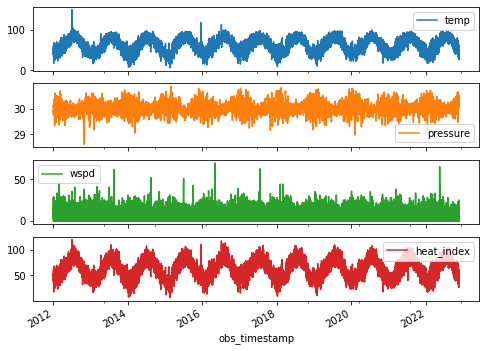

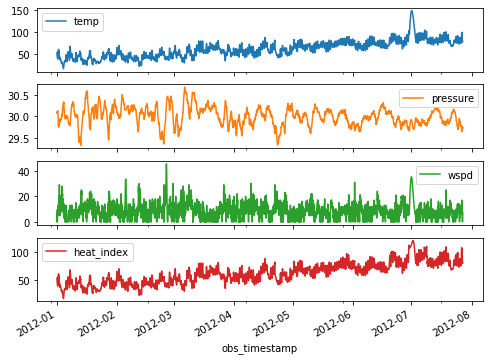

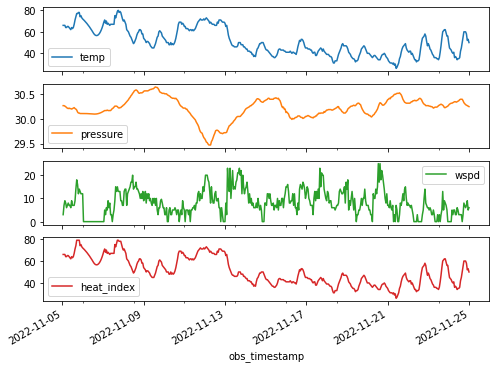

In [9]:
plot_cols = ['temp', 'pressure', 'wspd', 'heat_index']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:5000]
plot_features.index = date_time[:5000]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][-480:]
plot_features.index = date_time[-480:]
_ = plot_features.plot(subplots=True)

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,95544.0,5.990072e+01,17.726894,6.000000,46.000000,6.100000e+01,75.000000,149.633106
pressure,95544.0,3.004453e+01,0.213933,28.610000,29.910000,3.004000e+01,30.180000,30.860000
wspd,95544.0,8.526165e+00,5.495707,0.000000,5.000000,8.000000e+00,12.000000,69.244278
heat_index,95544.0,6.048182e+01,18.554310,6.000000,46.000000,6.100000e+01,75.000000,120.437159
dewPt,95544.0,4.606819e+01,19.121961,-15.000000,31.000000,4.800000e+01,63.000000,99.497308
rh,95544.0,6.295125e+01,19.163733,0.000000,48.000000,6.300000e+01,79.000000,100.000000
vis,95544.0,9.522174e+00,1.623332,0.000000,10.000000,1.000000e+01,10.000000,10.000000
wc,95544.0,5.823950e+01,20.103512,-11.000000,42.000000,6.100000e+01,75.000000,149.633106
wdir_degree,95544.0,1.807204e+02,114.786991,-1.000000,70.000000,1.900000e+02,290.000000,360.000000
clds_ordinal,95544.0,2.659058e+00,1.311174,0.000000,2.000000,3.000000e+00,4.000000,4.000000


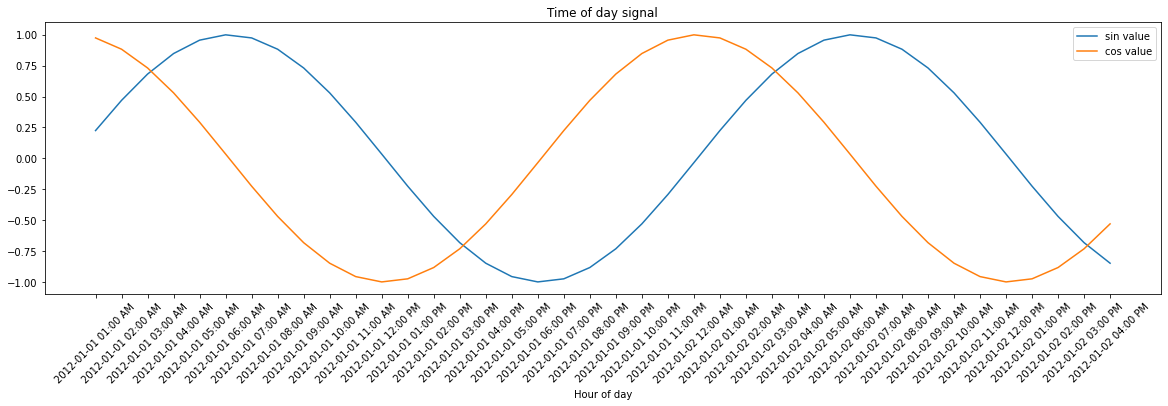

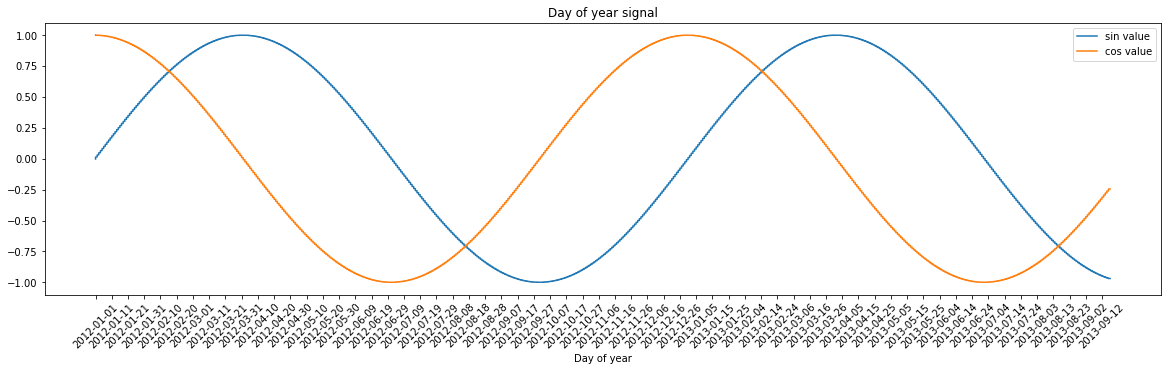

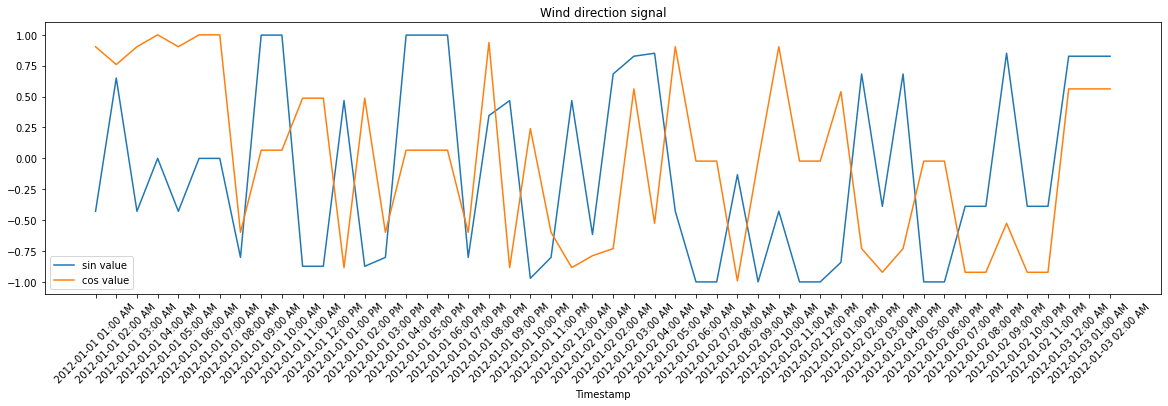

In [11]:
from datetime import datetime, timedelta
fig, ax = plt.subplots(figsize=(20, 5))

def get_date_and_time(val):
  dt = val + timedelta(minutes=8)
  return dt.strftime("%Y-%m-%d %I:%M %p")

def get_date(val):
  dt = val + timedelta(minutes=8)
  return dt.strftime("%Y-%m-%d")  

xlabels = date_time.apply(get_date_and_time)

xticks = xlabels[:40]
_ = ax.plot(xticks, np.array(df['day_sin'])[:40])
_ = ax.plot(xticks, np.array(df['day_cos'])[:40])
ax.set_xlabel('Hour of day')
ax.set_title('Time of day signal')
ax.set_xticklabels(xticks, rotation = 45)
plt.legend(labels=['sin value','cos value'])

fig2, ax2 = plt.subplots(figsize=(20, 5))

xlabels_yr = date_time.apply(get_date)
xticks_yr = xlabels_yr[:15000]
_ = ax2.plot(xticks_yr, np.array(df['year_sin'])[:15000])
_ = ax2.plot(xticks_yr, np.array(df['year_cos'])[:15000])
ax2.set_xlabel('Day of year')
ax2.set_title('Day of year signal')
ax2.set_xticklabels(xticks_yr, rotation = 45)
ax2.set_xticks(xticks_yr[::240])
ax2.set_xticklabels(xticks_yr[::240], rotation=45)
plt.legend(labels=['sin value','cos value'])


fig3, ax3 = plt.subplots(figsize=(20, 5))

xticks_wdir = xlabels[:50]
_ = ax3.plot(xticks_wdir, np.array(df['wdir_sin'])[:50])
_ = ax3.plot(xticks_wdir, np.array(df['wdir_cos'])[:50])
ax3.set_xlabel('Timestamp')
ax3.set_title('Wind direction signal')
ax3.set_xticklabels(xticks_wdir, rotation = 45)
# ax2.set_xticks(xticks_yr[::240])
# ax2.set_xticklabels(xticks_yr[::240], rotation=45)
plt.legend(labels=['sin value','cos value'])

In [13]:
# Split data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns="temp"):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

  def plot(self, model=None, plot_col='temp', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    

In [15]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ["pressure", "wspd","heat_index","dewPt", "rh",	"vis", "wc", "clds_ordinal",
             "day_sin", "day_cos", "year_sin", "year_cos", "wdir_sin", "wdir_cos"]

train_df_features = train_df[cols_to_scale]
scaler = StandardScaler().fit(train_df_features.values)

train_df_features = scaler.transform(train_df_features.values)
train_df[cols_to_scale] = train_df_features
val_df_features = val_df[cols_to_scale]
val_df_features = scaler.transform(val_df_features.values)
val_df[cols_to_scale] = val_df_features
test_df_features = test_df[cols_to_scale]
test_df_features = scaler.transform(test_df_features.values)
test_df[cols_to_scale] = test_df_features
train_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,temp,pressure,wspd,heat_index,dewPt,rh,vis,wc,wdir_degree,clds_ordinal,day_sin,day_cos,year_sin,year_cos,wdir_sin,wdir_cos
0,53.0,0.180597,0.081844,-0.388374,-0.397818,-0.290264,0.301218,-0.244116,320.0,0.245160,0.318017,1.378038,-0.053779,1.428382,-0.595909,1.127498
1,52.0,0.180597,-0.096663,-0.441261,-0.449036,-0.290264,0.301218,-0.292749,340.0,0.245160,0.663824,1.248748,-0.052758,1.428384,0.968098,0.926850
2,50.0,0.273474,-0.453676,-0.547035,-0.449036,-0.082776,0.301218,-0.390014,320.0,-1.283845,0.964385,1.034363,-0.051738,1.428386,-0.595909,1.127498
3,48.0,0.319913,-1.524716,-0.652809,-0.449036,0.176584,0.301218,-0.487279,0.0,-1.283845,1.199217,0.749494,-0.050718,1.428387,0.025008,1.261639
4,48.0,0.319913,-0.453676,-0.652809,-0.449036,0.176584,0.301218,-0.584545,320.0,-0.519343,1.352316,0.413554,-0.049698,1.428387,-0.595909,1.127498


In [16]:
val_df.head()

,temp,pressure,wspd,heat_index,dewPt,rh,vis,wc,wdir_degree,clds_ordinal,day_sin,day_cos,year_sin,year_cos,wdir_sin,wdir_cos
66880,92.0,-0.283787,-0.275169,1.938649,1.189937,-0.808984,0.301218,1.652558,170.0,-0.519343,-1.352544,-0.413391,-1.083047,-0.947047,0.527724,1.175264
66881,92.0,-0.330225,-0.275169,1.938649,1.189937,-0.808984,0.301218,1.652558,160.0,-0.519343,-1.413478,-0.049273,-1.083749,-0.946315,0.343222,-1.490471
66882,92.0,-0.330225,0.260351,2.044423,1.292373,-0.653368,0.301218,1.652558,120.0,-0.519343,-1.378093,0.318208,-1.084450,-0.945582,0.867019,1.002788
66883,92.0,-0.469541,0.081844,2.150196,1.394809,-0.445880,0.301218,1.652558,120.0,-0.519343,-1.248801,0.664009,-1.085151,-0.944849,0.867019,1.002788
66884,95.0,-0.515979,-0.096663,2.150196,1.241155,-0.964600,0.301218,1.798456,170.0,-0.519343,-1.034413,0.964565,-1.085851,-0.944116,0.527724,1.175264


In [17]:
MAX_EPOCHS = 300
from os.path import exists

def compile_and_fit(model, window, patience=5, checkpoint_path=None, 
                    epochs=MAX_EPOCHS, 
                    lossfn=tf.keras.losses.MeanAbsoluteError(), 
                    learning_rate=1e-3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  callbacks = [early_stopping]
  save_path = None
  if checkpoint_path:
    save_path = checkpoint_path + ".h5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path, save_freq="epoch", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks.append(checkpoint)

  model.compile(
      loss=lossfn,
      optimizer=tf.keras.optimizers.Adam()
  )

  history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=callbacks)
  return history

Total window size: 192
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): ['temp']

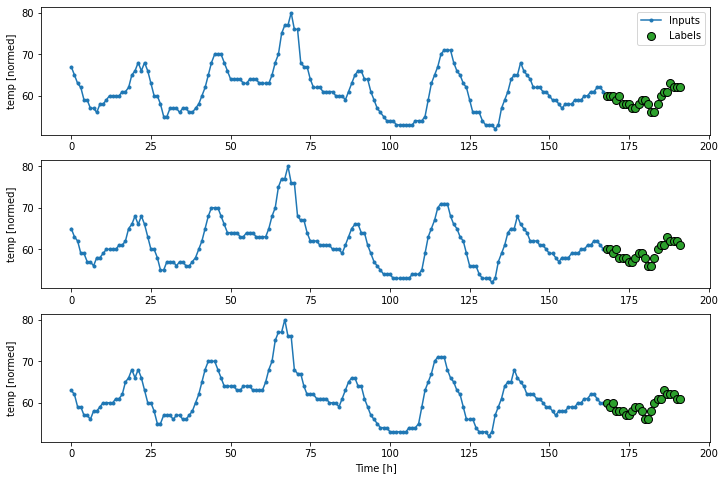

In [18]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=168, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['temp']
)
multi_window.plot()
multi_window

592/592 [==============================] - 2s 2ms/step - loss: 62.1017


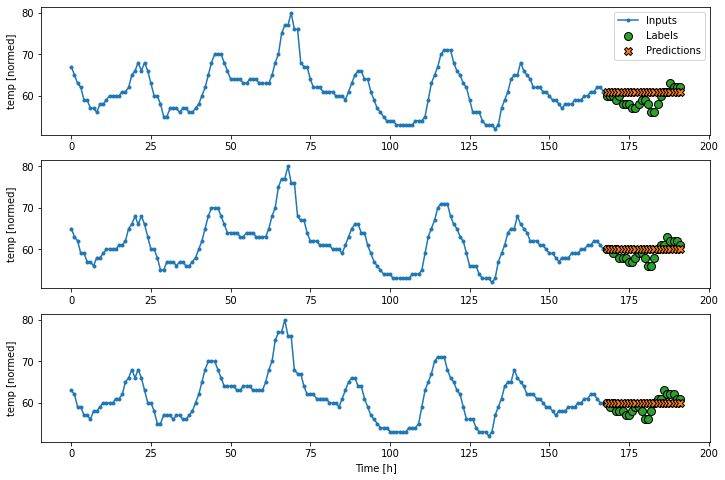

In [19]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    pred = tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
    return pred

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanAbsoluteError())

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

592/592 [==============================] - 1s 2ms/step - loss: 62.0159


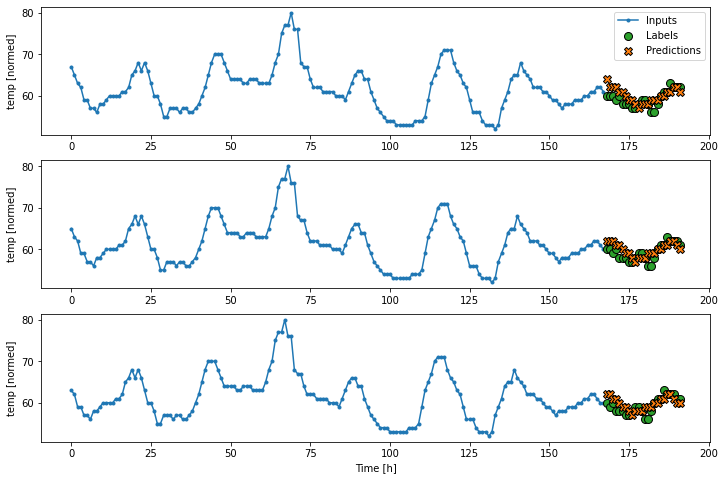

In [20]:
repeat_window = WindowGenerator(
    input_width=168, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['temp']
)

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    input_slice = inputs[-1, -24:, :]
    a = tf.slice(inputs,
               begin=[0,144,0],
               size=[-1, 24,-1])
    return a

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanAbsoluteError())

multi_val_performance['Repeat'] = repeat_baseline.evaluate(repeat_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(repeat_window.test, verbose=0)
repeat_window.plot(repeat_baseline)

In [21]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(12, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(
    multi_lstm_model, 
    multi_window, 
    checkpoint_path="/content/drive/MyDrive/MSML-602-Final-Project/models/latest-checkpoint",
    epochs=50,
    lossfn=tf.keras.losses.MeanAbsoluteError(),
)


Epoch 1/50
2085/2085 [==============================] - ETA: 0s - loss: 45.2640
Epoch 1: val_loss improved from inf to 32.10857, saving model to /content/drive/MyDrive/MSML-602-Final-Project/models/latest-checkpoint.h5
2085/2085 [==============================] - 30s 10ms/step - loss: 45.2640 - val_loss: 32.1086
Epoch 2/50
2084/2085 [============================>.] - ETA: 0s - loss: 22.7850
Epoch 2: val_loss improved from 32.10857 to 16.41848, saving model to /content/drive/MyDrive/MSML-602-Final-Project/models/latest-checkpoint.h5
2085/2085 [==============================] - 19s 9ms/step - loss: 22.7852 - val_loss: 16.4185
Epoch 3/50
2081/2085 [============================>.] - ETA: 0s - loss: 12.4648
Epoch 3: val_loss improved from 16.41848 to 10.35024, saving model to /content/drive/MyDrive/MSML-602-Final-Project/models/latest-checkpoint.h5
2085/2085 [==============================] - 20s 9ms/step - loss: 12.4725 - val_loss: 10.3502
Epoch 4/50
2080/2085 [============================

In [ ]:
## Code to Resume training from checkpoint
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=5,
#                                                     mode='min')
# save_path = '/content/drive/MyDrive/MSML-602-Final-Project/models/latest-checkpoint.h5'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path, save_freq="epoch", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# callbacks = [early_stopping, checkpoint]


# loaded_model = tf.keras.models.load_model(save_path)
# _history = loaded_model.fit(multi_window.train, epochs=50,
#                     validation_data=multi_window.val,
#                     callbacks=callbacks,
#                     )

592/592 [==============================] - 3s 5ms/step - loss: 3.7343


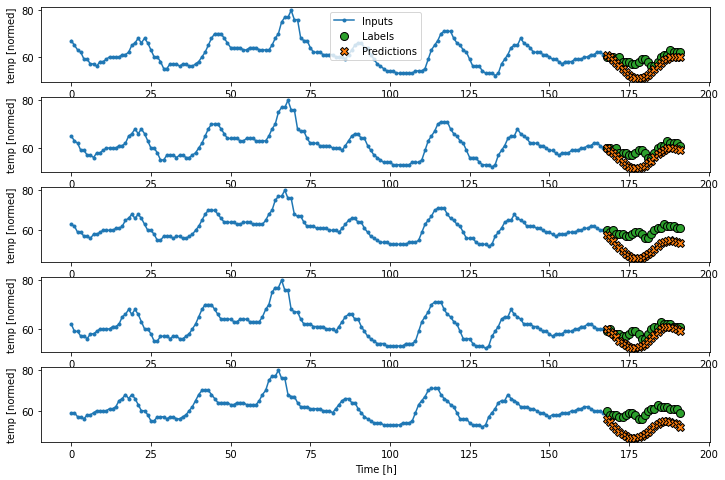

In [22]:
IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, max_subplots=5)

In [23]:
# Save model
multi_lstm_model.save('/content/drive/MyDrive/MSML-602-Final-Project/models/latest-full-v2')

{'Last': 60.98268508911133, 'Repeat': 60.92747497558594, 'LSTM': 4.063677787780762}


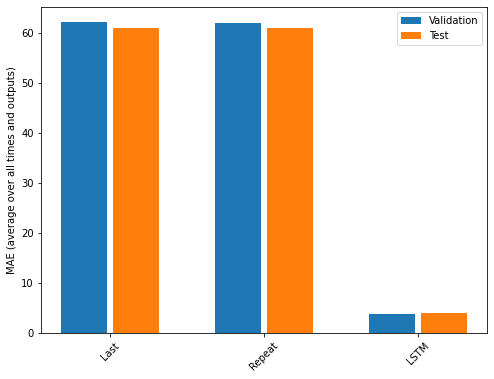

In [24]:

x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
# metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in multi_val_performance.values()]
# test_mae = [v[metric_index] for v in multi_performance.values()]
val_mae = [v for v in multi_val_performance.values()]
test_mae = [v for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

print(multi_performance)

In [25]:
conn = sqlite3.connect("./data/weather-clean.db")
predict_df = pd.read_sql("""
SELECT 
  temp, obs_timestamp, pressure, wspd, 
  heat_index, dewPt, rh, vis, wc,
  wdir, wdir_cardinal, clds
FROM weather_clean
WHERE obs_timestamp > DATETIME('2022-12-06 23:52:00', '-7 days')
""",
  conn,
  parse_dates=["obs_timestamp"]
)


predict_df, dtime = prepare_dataframe(predict_df, "2022-11-06 00:52:00", "2022-12-06 23:52:00")
dtime

576   2022-11-30 00:52:00
577   2022-11-30 01:52:00
578   2022-11-30 02:52:00
579   2022-11-30 03:52:00
580   2022-11-30 04:52:00
              ...        
739   2022-12-06 19:52:00
740   2022-12-06 20:52:00
741   2022-12-06 21:52:00
742   2022-12-06 22:52:00
743   2022-12-06 23:52:00
Name: obs_timestamp, Length: 168, dtype: datetime64[ns]

In [26]:
predict_df_features = predict_df[cols_to_scale]
predict_df_features = scaler.transform(predict_df_features.values)
predict_df[cols_to_scale] = predict_df_features
predict_df

,temp,pressure,wspd,heat_index,dewPt,rh,vis,wc,wdir_degree,clds_ordinal,day_sin,day_cos,year_sin,year_cos,wdir_sin,wdir_cos
576,47.0,0.830736,-0.096663,-0.705696,-0.500254,0.176584,0.301218,-0.730443,160.0,0.245160,0.318017,1.378038,-0.790918,1.222822,0.343222,-1.490471
577,46.0,0.784297,-0.453676,-0.758583,-0.500254,0.280328,0.301218,-0.730443,150.0,0.245160,0.663824,1.248748,-0.790046,1.223346,-1.011716,0.842687
578,45.0,0.830736,-0.275169,-0.811469,-0.449036,0.591560,0.301218,-0.827708,190.0,0.245160,0.964385,1.034363,-0.789175,1.223870,1.472031,-0.039023
579,45.0,0.737859,-0.453676,-0.811469,-0.397818,0.695304,0.301218,-0.779075,180.0,0.245160,1.199217,0.749494,-0.788302,1.224394,-1.136835,-0.965063
580,46.0,0.598543,-0.096663,-0.758583,-0.295382,0.850920,0.301218,-0.779075,180.0,1.009662,1.352316,0.413554,-0.787430,1.224916,-1.136835,-0.965063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,47.0,0.737859,-0.275169,-0.705696,-0.039293,1.577128,-2.704276,-0.681810,180.0,1.009662,-1.248801,0.664009,-0.644174,1.299995,-1.136835,-0.965063
740,47.0,0.784297,-0.275169,-0.705696,0.011925,1.784616,-3.305375,-0.681810,180.0,1.009662,-1.034413,0.964565,-0.643247,1.300415,-1.136835,-0.965063
741,48.0,0.784297,-0.275169,-0.652809,0.011925,1.577128,-2.704276,-0.633177,180.0,1.009662,-0.749539,1.199393,-0.642319,1.300835,-1.136835,-0.965063
742,48.0,0.784297,-0.096663,-0.652809,0.011925,1.577128,-2.704276,-0.681810,180.0,1.009662,-0.413594,1.352490,-0.641391,1.301255,-1.136835,-0.965063


In [27]:
multi_lstm_model.input_shape

(None, 168, 16)

In [28]:
multi_lstm_model.output_shape

(None, 24, 1)

In [29]:

predictions = multi_lstm_model(predict_df.to_numpy().reshape(1, 168, 16))
predictions

<tf.Tensor: shape=(1, 24, 1), dtype=float32, numpy=
array([[[50.56905 ],
        [49.71711 ],
        [48.851936],
        [48.09685 ],
        [47.454166],
        [47.103348],
        [46.94274 ],
        [47.055454],
        [47.360664],
        [47.958668],
        [48.661747],
        [49.47821 ],
        [50.41795 ],
        [51.497894],
        [52.599434],
        [53.645515],
        [54.513523],
        [55.051838],
        [55.343483],
        [55.2045  ],
        [54.770206],
        [54.091217],
        [53.263943],
        [52.350563]]], dtype=float32)>

In [30]:
# Code to save scaler
import pickle
pickle.dump(scaler, open('/content/drive/MyDrive/MSML-602-Final-Project/models/scaler-v2.pkl','wb'))

# Code to load scaler
# scaler = pickle.load(open('file/path/scaler.pkl','rb'))